Importing Libraries:

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# base_image_path = keras.utils.get_file("Toronto.jpg")
base_image_path = "Toronto.jpg"

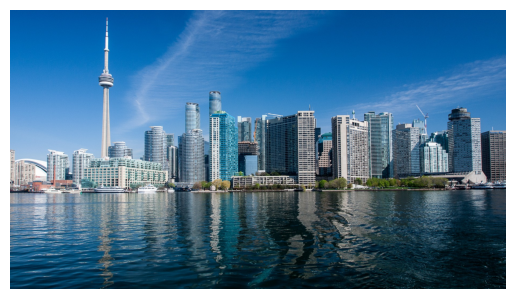

In [5]:
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path));

In [6]:
from tensorflow.keras.applications import inception_v3

Using the pretrained Model:

In [7]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [8]:
layer_settings = {
    "mixed4" : 1.0,
    "mixed5" : 1.5,
    "mixed6" : 2.0,
    "mixed7" : 1.5,
}

In [9]:
outputs_dict = dict(
    [
        (layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

In [11]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Defining functions for the architecture of the model:

In [2]:
def compute_loss(input_image):
    """
    Computes the loss based on the features extracted from the input image.

    Args:
        input_image: A tensor representing the input image.

    Returns:
        loss: A scalar tensor representing the computed loss.
    """
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss
    

In [5]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    """
    Performs a single step of gradient ascent to maximize the loss with respect to the input image.

    Args:
        image: A tensor representing the input image.
        learning_rate: A scalar tensor representing the learning rate for the gradient ascent.

    Returns:
        loss: A scalar tensor representing the computed loss.
        image: A tensor representing the updated input image after the gradient ascent step.
    """
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

In [6]:
def gradient_ascent_loops(image, iterations, learning_rate, max_loss=None):
    """
    Performs multiple steps of gradient ascent to maximize the loss with respect to the input image.

    Args:
        image: A tensor representing the input image.
        iterations: An integer specifying the number of iterations for gradient ascent.
        learning_rate: A scalar tensor representing the learning rate for gradient ascent steps.
        max_loss: Optional. A scalar tensor specifying the maximum loss value to terminate gradient ascent.
                  If provided, the function stops iterating when the loss exceeds this value.

    Returns:
        image: A tensor representing the input image after multiple gradient ascent steps.
    """
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)

        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [16]:
step = 20
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [17]:
import numpy as np

In [7]:
def preprocess_image(image_path):
    """
    Preprocesses an image before feeding it into a neural network.

    Args:
        image_path: A string representing the path to the input image file.

    Returns:
        img: A numpy array representing the preprocessed image ready for model input.
    """
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis =0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img


In [8]:
def deprocess_image(img):
    """
    Deprocesses an image after it has been processed by a neural network.

    Args:
        img: A numpy array representing the processed image.

    Returns:
        img: A numpy array representing the deprocessed image ready for visualization.
    """
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0 , 255).astype("uint8")
    return img

In [22]:
original_img = preprocess_image(base_image_path)

In [23]:
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])
img = tf.identity(original_img)

In [25]:
for i, shape in enumerate(successive_shapes):
    print(f"Preprocessing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loops(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Preprocessing octave 0 with shape (532, 946)
... Loss value at step 0: 4.56
... Loss value at step 1: 6.83
... Loss value at step 2: 7.83
... Loss value at step 3: 8.70
... Loss value at step 4: 9.22
... Loss value at step 5: 9.91
... Loss value at step 6: 10.27
... Loss value at step 7: 10.76
... Loss value at step 8: 11.16
... Loss value at step 9: 11.55
... Loss value at step 10: 11.91
... Loss value at step 11: 12.23
... Loss value at step 12: 12.46
... Loss value at step 13: 12.86
... Loss value at step 14: 13.09
... Loss value at step 15: 13.41
... Loss value at step 16: 13.62
... Loss value at step 17: 13.92
... Loss value at step 18: 14.15
... Loss value at step 19: 14.44
... Loss value at step 20: 14.63
... Loss value at step 21: 14.87
Preprocessing octave 1 with shape (745, 1325)
... Loss value at step 0: 3.51
... Loss value at step 1: 5.47
... Loss value at step 2: 6.52
... Loss value at step 3: 7.25
... Loss value at step 4: 7.78
... Loss value at step 5: 8.49
... Loss valu